<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE (Variational AutoEncoders)

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_3000.zip -d ./data3000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 34.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 62.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, title=None):

    plt.plot(loss_train_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train data'], loc=0)
    # plt.show()

# function to visualize the latent space manifold
def plot_latent_space(vae, n=10, digit_size=56):

    # create an empty array to hold the grid of images
    figure = np.zeros((digit_size * n, digit_size * n))

    # generate linear spaces for the x and y axes (latent dimensions)
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    # loop over the grid coordinates and decode latent points to images
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            # sample a point (xi, yi) from the latent space and convert to a tensor
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to('cuda')

            # use the decoder to generate an image from the latent vector z_sample
            x_decoded = vae.decoder(z_sample).cpu().detach().numpy()

            # reshape the output to the digit size (56x56)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # place the generated image into the figure grid at position (i, j)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # plot the grid of generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

# function for linear interpolation between two points in the latent space
def linear_interpolation(x_from, x_to, steps=10):
    """
    Performs linear interpolation between two points in latent space.

    Args:
    - x_from: Starting latent vector (latent dimension).
    - x_to: Ending latent vector (latent dimension).
    - steps: Number of interpolation steps (default is 10).

    Returns:
    - inter: Interpolated latent vectors between x_from and x_to.
    """
    n = steps + 1  # number of interpolation points (including start and end)

    t_from = x_from  # starting point in the latent space
    t_to = x_to  # ending point in the latent space

    # compute the difference between the two latent vectors
    diff = t_to - t_from

    # initialize an array to store the interpolated vectors
    inter = np.zeros((n, t_from.shape[0]))

    # perform the linear interpolation
    for i in range(n):
        inter[i] = t_from + (i / steps) * diff  # linearly interpolate between the two vectors

    return inter  # return the interpolated vectors

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data3000/22.5651.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data3000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(float(file[:-4]))  # extract label from filename

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (3000, 56, 56) Y.shape: (3000,)


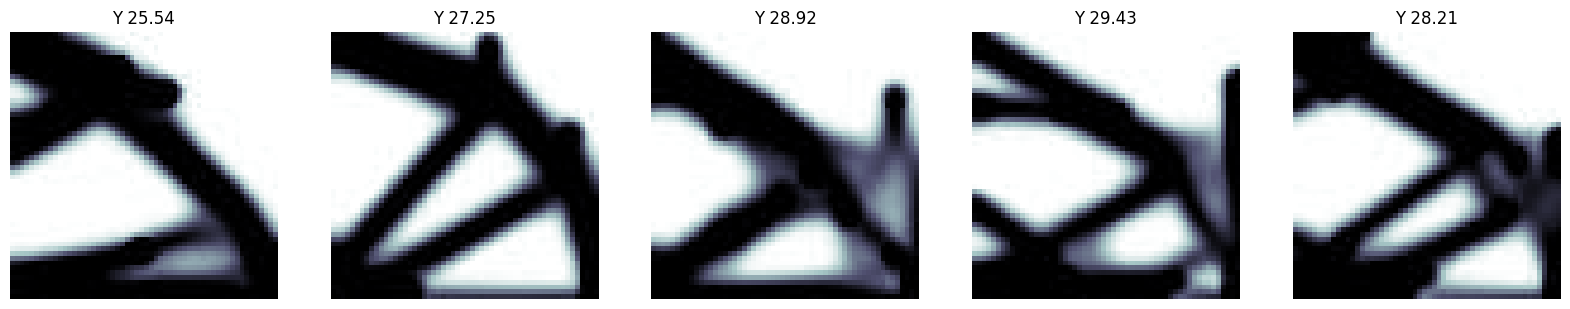

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [ ]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

(2400, 56, 56) (600, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2400,) (600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## 6. Set to model architecture

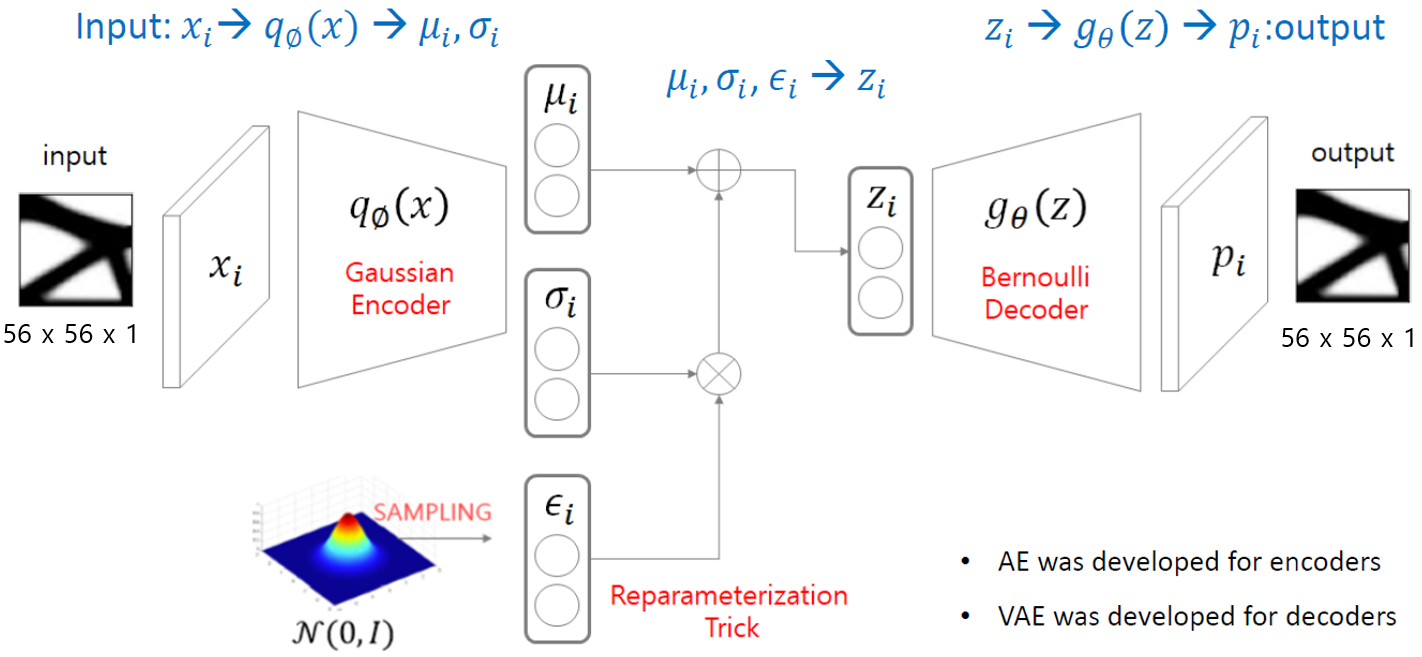

https://taeu.github.io/paper/deeplearning-paper-vae/

In [ ]:
# define the Encoder module
class Encoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, intermediate_dim)  # first hidden layer
        self.fc2_mean = nn.Linear(intermediate_dim, latent_dim)  # output for mean
        self.fc2_logvar = nn.Linear(intermediate_dim, latent_dim)  # output for log variance

    def forward(self, x):
        h = torch.relu(self.fc1(x))  # apply ReLU activation to the first layer
        z_mean = self.fc2_mean(h)  # mean of the latent distribution
        z_logvar = self.fc2_logvar(h)  # log variance of the latent distribution

        return z_mean, z_logvar  # return both mean and log variance

In [ ]:
# define the Decoder module
class Decoder(nn.Module):
    def __init__(self, latent_dim, intermediate_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, intermediate_dim)  # latent space to hidden layer
        self.fc2 = nn.Linear(intermediate_dim, output_dim)  # hidden layer to output (original image size)

    def forward(self, z):
        h = torch.relu(self.fc1(z))  # apply ReLU activation to the hidden layer
        x_recon = torch.sigmoid(self.fc2(h))  # Sigmoid activation to ensure output is in [0,1] range

        return x_recon  # return the reconstructed image

In [ ]:
# define the full Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, intermediate_dim, latent_dim)  # encoder network
        self.decoder = Decoder(latent_dim, intermediate_dim, input_dim)  # decoder network

    # reparameterization trick: sample from the latent distribution
    def reparameterize(self, z_mean, z_logvar):
        epsilon = torch.randn_like(z_mean)  # random noise sampled from a standard normal distribution

        return z_mean + torch.exp(0.5 * z_logvar) * epsilon  # sample z using mean and variance

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)  # get the mean and log variance from encoder
        z = self.reparameterize(z_mean, z_logvar)  # sample z using the reparameterization trick
        x_recon = self.decoder(z)  # reconstruct the input from the sampled z

        return x_recon, z_mean, z_logvar  # return reconstructed image, mean, and log variance

## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
input_dim = train_images.shape[1]  # flattened image size (56*56 = 3136)
intermediate_dim = 512  # hidden layer dimension
latent_dim = 2  # latent space dimension (z-dim)

# training parameters
num_epochs = 300
batch_size = 20
learning_rate = 1e-3

In [ ]:
vae = VAE(input_dim, intermediate_dim, latent_dim).to(device)

# print the model summary
summary(vae, (input_dim,))

vae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
            Linear-2                    [-1, 2]           1,026
            Linear-3                    [-1, 2]           1,026
           Encoder-4         [[-1, 2], [-1, 2]]               0
            Linear-5                  [-1, 512]           1,536
            Linear-6                 [-1, 3136]       1,608,768
           Decoder-7                 [-1, 3136]               0
Total params: 3,218,500
Trainable params: 3,218,500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.28
Estimated Total Size (MB): 12.35
----------------------------------------------------------------


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=3136, out_features=512, bias=True)
    (fc2_mean): Linear(in_features=512, out_features=2, bias=True)
    (fc2_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=3136, bias=True)
  )
)

## 8. Train model

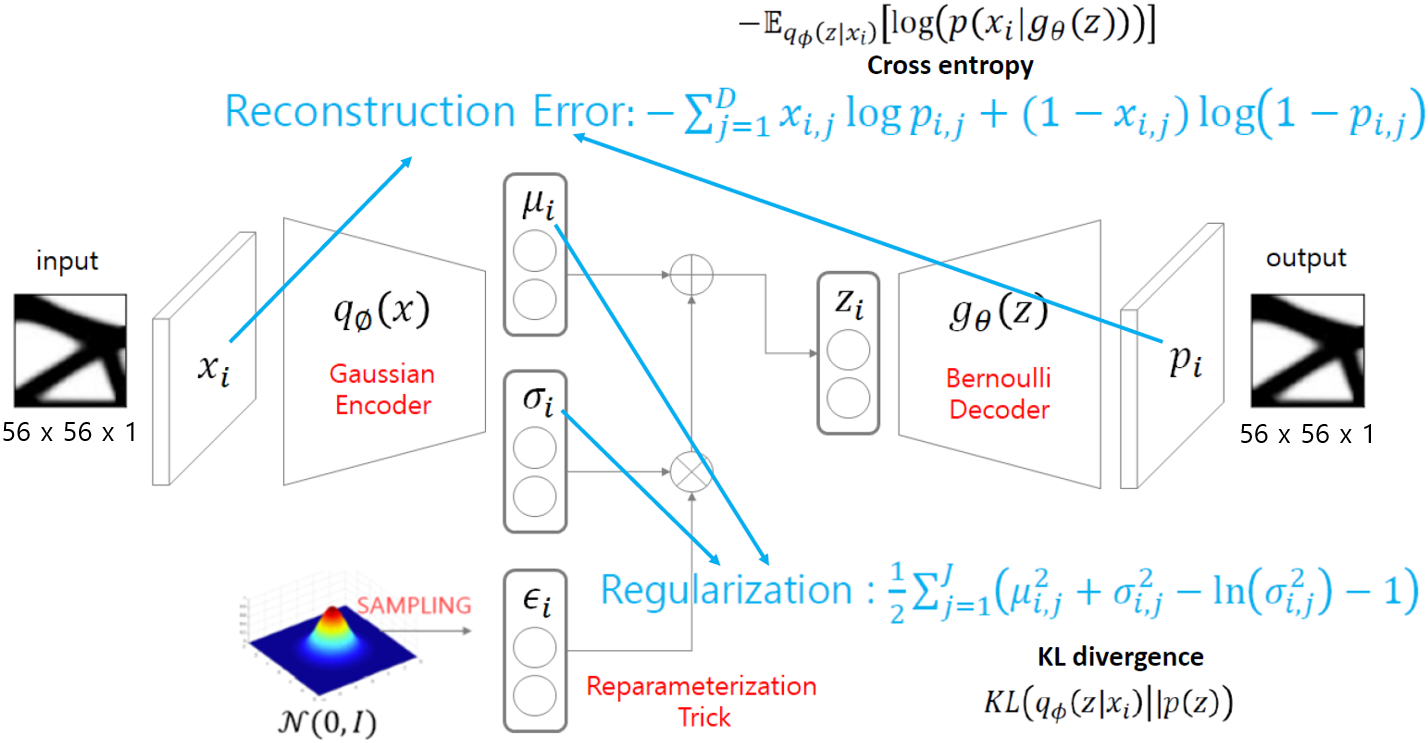

https://taeu.github.io/paper/deeplearning-paper-vae/

Epoch [1/300], Train_loss: 8.9714


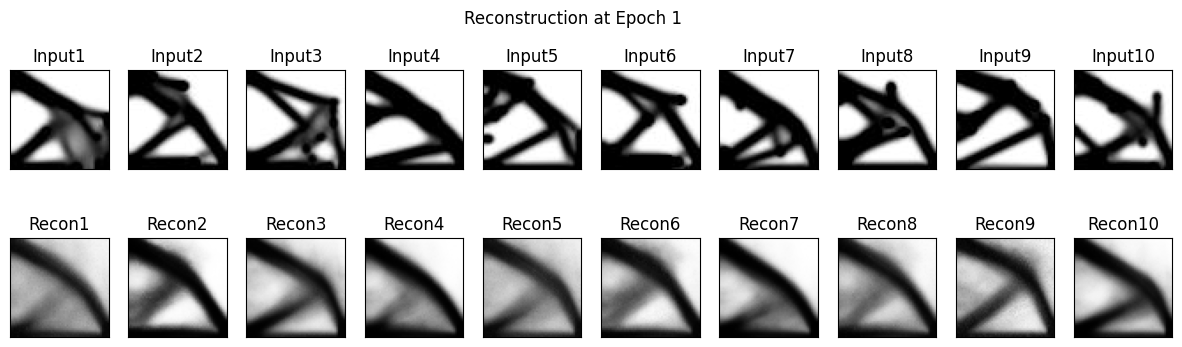

Epoch [2/300], Train_loss: 8.2323
Epoch [3/300], Train_loss: 8.0952
Epoch [4/300], Train_loss: 8.0482
Epoch [5/300], Train_loss: 7.9912
Epoch [6/300], Train_loss: 7.9645
Epoch [7/300], Train_loss: 7.9371
Epoch [8/300], Train_loss: 7.9119
Epoch [9/300], Train_loss: 7.9025
Epoch [10/300], Train_loss: 7.8824
Epoch [11/300], Train_loss: 7.8711
Epoch [12/300], Train_loss: 7.8503
Epoch [13/300], Train_loss: 7.8453
Epoch [14/300], Train_loss: 7.8265
Epoch [15/300], Train_loss: 7.8223
Epoch [16/300], Train_loss: 7.8061
Epoch [17/300], Train_loss: 7.7877
Epoch [18/300], Train_loss: 7.7859
Epoch [19/300], Train_loss: 7.7871
Epoch [20/300], Train_loss: 7.7704
Epoch [21/300], Train_loss: 7.7620
Epoch [22/300], Train_loss: 7.7580
Epoch [23/300], Train_loss: 7.7462
Epoch [24/300], Train_loss: 7.7286
Epoch [25/300], Train_loss: 7.7342
Epoch [26/300], Train_loss: 7.7119
Epoch [27/300], Train_loss: 7.7207
Epoch [28/300], Train_loss: 7.7201
Epoch [29/300], Train_loss: 7.7058
Epoch [30/300], Train_loss: 

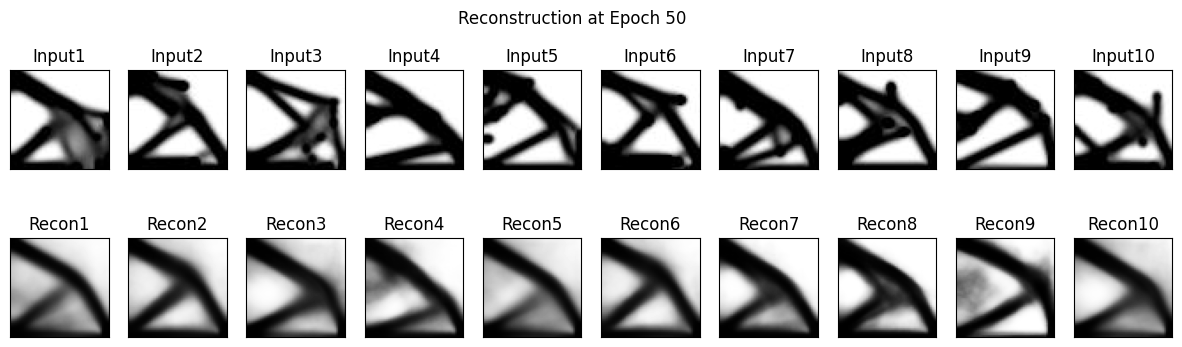

Epoch [51/300], Train_loss: 7.5697
Epoch [52/300], Train_loss: 7.5779
Epoch [53/300], Train_loss: 7.5736
Epoch [54/300], Train_loss: 7.5702
Epoch [55/300], Train_loss: 7.5632
Epoch [56/300], Train_loss: 7.5637
Epoch [57/300], Train_loss: 7.5528
Epoch [58/300], Train_loss: 7.5537
Epoch [59/300], Train_loss: 7.5558
Epoch [60/300], Train_loss: 7.5406
Epoch [61/300], Train_loss: 7.5467
Epoch [62/300], Train_loss: 7.5344
Epoch [63/300], Train_loss: 7.5411
Epoch [64/300], Train_loss: 7.5250
Epoch [65/300], Train_loss: 7.5185
Epoch [66/300], Train_loss: 7.5182
Epoch [67/300], Train_loss: 7.5134
Epoch [68/300], Train_loss: 7.5147
Epoch [69/300], Train_loss: 7.5208
Epoch [70/300], Train_loss: 7.5112
Epoch [71/300], Train_loss: 7.5107
Epoch [72/300], Train_loss: 7.5041
Epoch [73/300], Train_loss: 7.4992
Epoch [74/300], Train_loss: 7.4848
Epoch [75/300], Train_loss: 7.4943
Epoch [76/300], Train_loss: 7.4918
Epoch [77/300], Train_loss: 7.4888
Epoch [78/300], Train_loss: 7.4896
Epoch [79/300], Trai

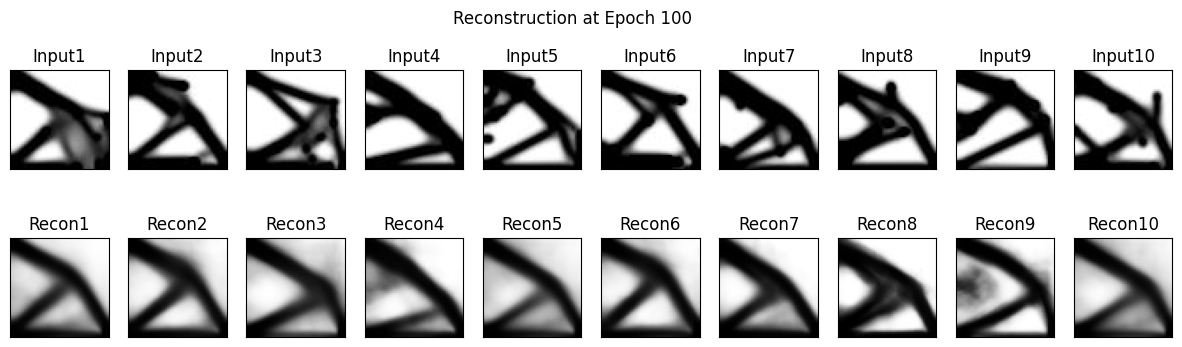

Epoch [101/300], Train_loss: 7.4305
Epoch [102/300], Train_loss: 7.4241
Epoch [103/300], Train_loss: 7.4168
Epoch [104/300], Train_loss: 7.4129
Epoch [105/300], Train_loss: 7.4217
Epoch [106/300], Train_loss: 7.4124
Epoch [107/300], Train_loss: 7.3960
Epoch [108/300], Train_loss: 7.3983
Epoch [109/300], Train_loss: 7.3947
Epoch [110/300], Train_loss: 7.3923
Epoch [111/300], Train_loss: 7.3929
Epoch [112/300], Train_loss: 7.3938
Epoch [113/300], Train_loss: 7.4098
Epoch [114/300], Train_loss: 7.3809
Epoch [115/300], Train_loss: 7.3865
Epoch [116/300], Train_loss: 7.3925
Epoch [117/300], Train_loss: 7.3940
Epoch [118/300], Train_loss: 7.3938
Epoch [119/300], Train_loss: 7.3853
Epoch [120/300], Train_loss: 7.3751
Epoch [121/300], Train_loss: 7.3707
Epoch [122/300], Train_loss: 7.3975
Epoch [123/300], Train_loss: 7.3845
Epoch [124/300], Train_loss: 7.3698
Epoch [125/300], Train_loss: 7.3587
Epoch [126/300], Train_loss: 7.3638
Epoch [127/300], Train_loss: 7.3590
Epoch [128/300], Train_loss:

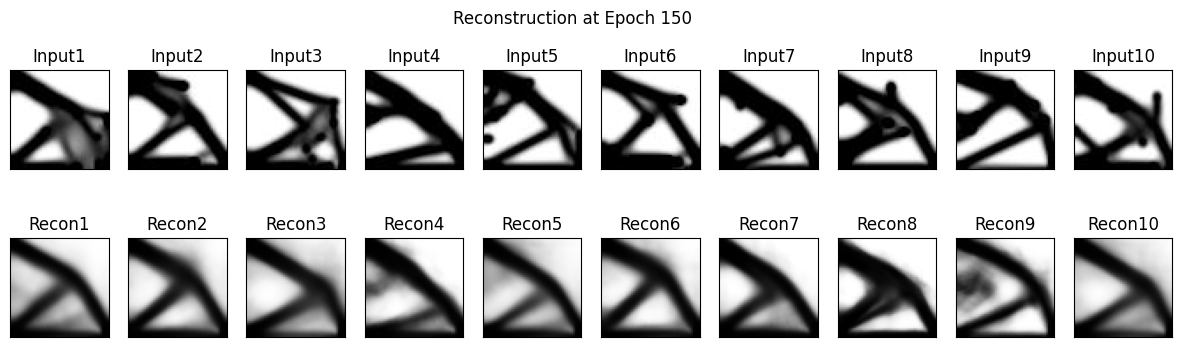

Epoch [151/300], Train_loss: 7.3069
Epoch [152/300], Train_loss: 7.3184
Epoch [153/300], Train_loss: 7.3222
Epoch [154/300], Train_loss: 7.3364
Epoch [155/300], Train_loss: 7.3063
Epoch [156/300], Train_loss: 7.3060
Epoch [157/300], Train_loss: 7.3124
Epoch [158/300], Train_loss: 7.3038
Epoch [159/300], Train_loss: 7.3131
Epoch [160/300], Train_loss: 7.3105
Epoch [161/300], Train_loss: 7.3124
Epoch [162/300], Train_loss: 7.3061
Epoch [163/300], Train_loss: 7.3017
Epoch [164/300], Train_loss: 7.2956
Epoch [165/300], Train_loss: 7.2970
Epoch [166/300], Train_loss: 7.2937
Epoch [167/300], Train_loss: 7.2822
Epoch [168/300], Train_loss: 7.2898
Epoch [169/300], Train_loss: 7.2943
Epoch [170/300], Train_loss: 7.2790
Epoch [171/300], Train_loss: 7.2770
Epoch [172/300], Train_loss: 7.2777
Epoch [173/300], Train_loss: 7.3067
Epoch [174/300], Train_loss: 7.2861
Epoch [175/300], Train_loss: 7.2878
Epoch [176/300], Train_loss: 7.2843
Epoch [177/300], Train_loss: 7.2723
Epoch [178/300], Train_loss:

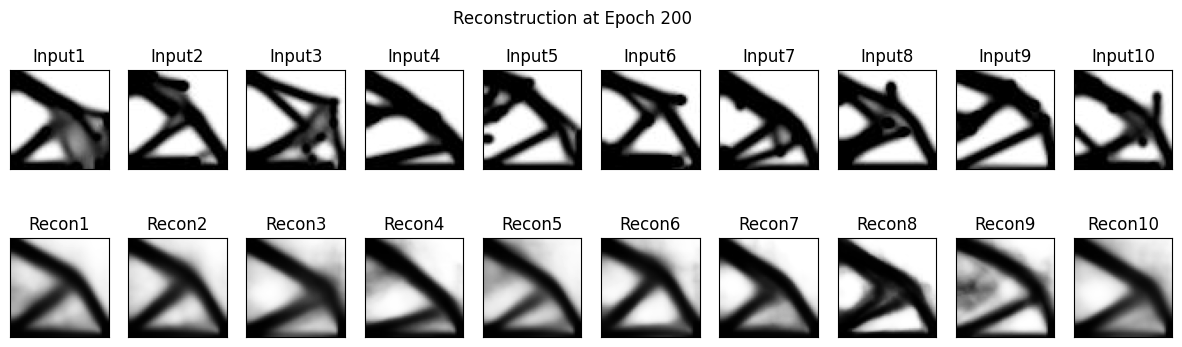

Epoch [201/300], Train_loss: 7.2519
Epoch [202/300], Train_loss: 7.2412
Epoch [203/300], Train_loss: 7.2514
Epoch [204/300], Train_loss: 7.2385
Epoch [205/300], Train_loss: 7.2383
Epoch [206/300], Train_loss: 7.2335
Epoch [207/300], Train_loss: 7.2559
Epoch [208/300], Train_loss: 7.2421
Epoch [209/300], Train_loss: 7.2571
Epoch [210/300], Train_loss: 7.2385
Epoch [211/300], Train_loss: 7.2388
Epoch [212/300], Train_loss: 7.2385
Epoch [213/300], Train_loss: 7.2349
Epoch [214/300], Train_loss: 7.2256
Epoch [215/300], Train_loss: 7.2505
Epoch [216/300], Train_loss: 7.2461
Epoch [217/300], Train_loss: 7.2308
Epoch [218/300], Train_loss: 7.2303
Epoch [219/300], Train_loss: 7.2285
Epoch [220/300], Train_loss: 7.2251
Epoch [221/300], Train_loss: 7.2300
Epoch [222/300], Train_loss: 7.2238
Epoch [223/300], Train_loss: 7.2191
Epoch [224/300], Train_loss: 7.2170
Epoch [225/300], Train_loss: 7.2242
Epoch [226/300], Train_loss: 7.2148
Epoch [227/300], Train_loss: 7.2217
Epoch [228/300], Train_loss:

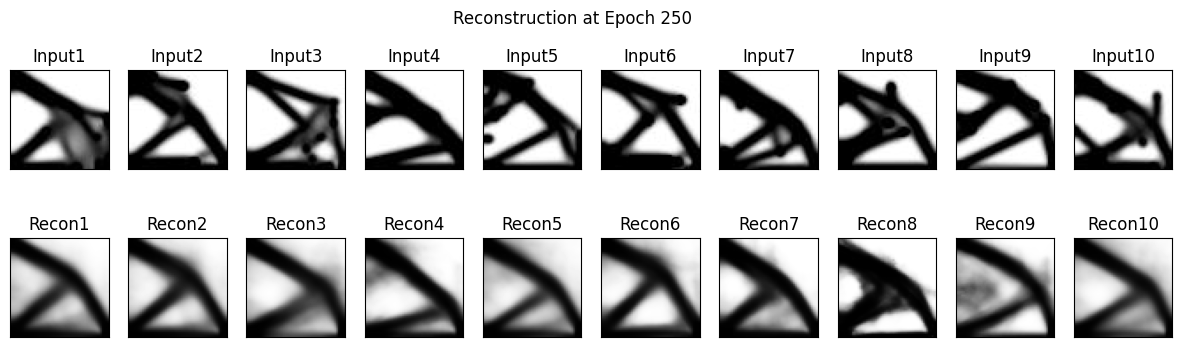

Epoch [251/300], Train_loss: 7.2054
Epoch [252/300], Train_loss: 7.2030
Epoch [253/300], Train_loss: 7.1872
Epoch [254/300], Train_loss: 7.1933
Epoch [255/300], Train_loss: 7.2093
Epoch [256/300], Train_loss: 7.1866
Epoch [257/300], Train_loss: 7.1946
Epoch [258/300], Train_loss: 7.1856
Epoch [259/300], Train_loss: 7.1829
Epoch [260/300], Train_loss: 7.1823
Epoch [261/300], Train_loss: 7.1783
Epoch [262/300], Train_loss: 7.1993
Epoch [263/300], Train_loss: 7.1892
Epoch [264/300], Train_loss: 7.1915
Epoch [265/300], Train_loss: 7.1856
Epoch [266/300], Train_loss: 7.1869
Epoch [267/300], Train_loss: 7.1948
Epoch [268/300], Train_loss: 7.1714
Epoch [269/300], Train_loss: 7.1749
Epoch [270/300], Train_loss: 7.1902
Epoch [271/300], Train_loss: 7.2069
Epoch [272/300], Train_loss: 7.1734
Epoch [273/300], Train_loss: 7.1719
Epoch [274/300], Train_loss: 7.1888
Epoch [275/300], Train_loss: 7.1714
Epoch [276/300], Train_loss: 7.1629
Epoch [277/300], Train_loss: 7.1722
Epoch [278/300], Train_loss:

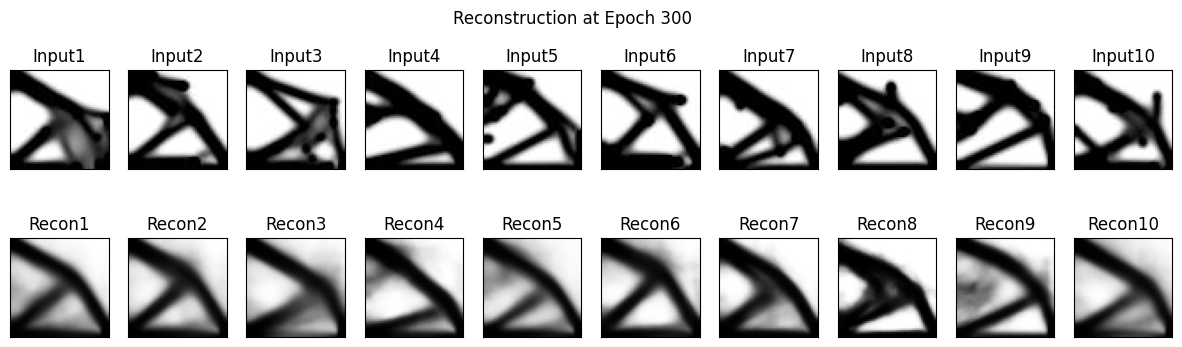

In [ ]:
# create a DataLoader for the training data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to optimizer & loss function

# define optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# define the loss function for VAE
def vae_loss(x, x_recon, z_mean, z_logvar):

    image_size = x.shape[1]  # image pixels (56x56 = 3136)

    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')  # Reconstruction loss (binary cross-entropy)
    kl_loss = 0.5 * torch.sum(z_mean.pow(2) +z_logvar.exp() -z_logvar -1)  # KL Divergence loss

    total_loss = (recon_loss + kl_loss) / image_size  # normalized total VAE loss

    return total_loss

# lists to track training and validation history
loss_train_history = []

# train the VAE model
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        x_recon, z_mean, z_logvar = vae(x)
        loss = vae_loss(x, x_recon, z_mean, z_logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train:.4f}")

    # perform inference every XX epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        vae.eval()
        recon_x_test, _, _ = vae(test_images)

        n = 10  # how many images to display
        plt.figure(figsize=(15, 4)) # figure size

        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
        plt.show()
        vae.train()  # switch back to training mode

# save the trained model
torch.save(vae.state_dict(), 'VAE_model.pth')

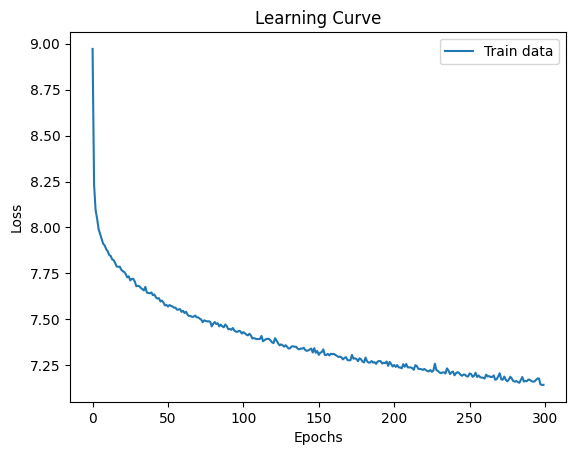

In [ ]:
# graph visualization
plot_loss(loss_train_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

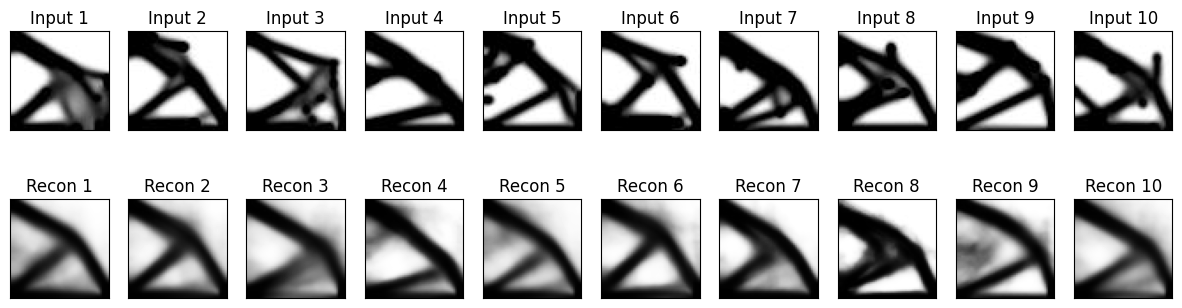

In [ ]:
# set the model to evaluation mode (no gradients will be computed)
vae.eval()

# reconstruct the test images using the trained VAE
with torch.no_grad():
    recon_x_test, _, _ = vae(test_images)

# visualize the original and reconstructed images

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title(f"Input {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title(f"Recon {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

- Plot latent space (2D) manifold

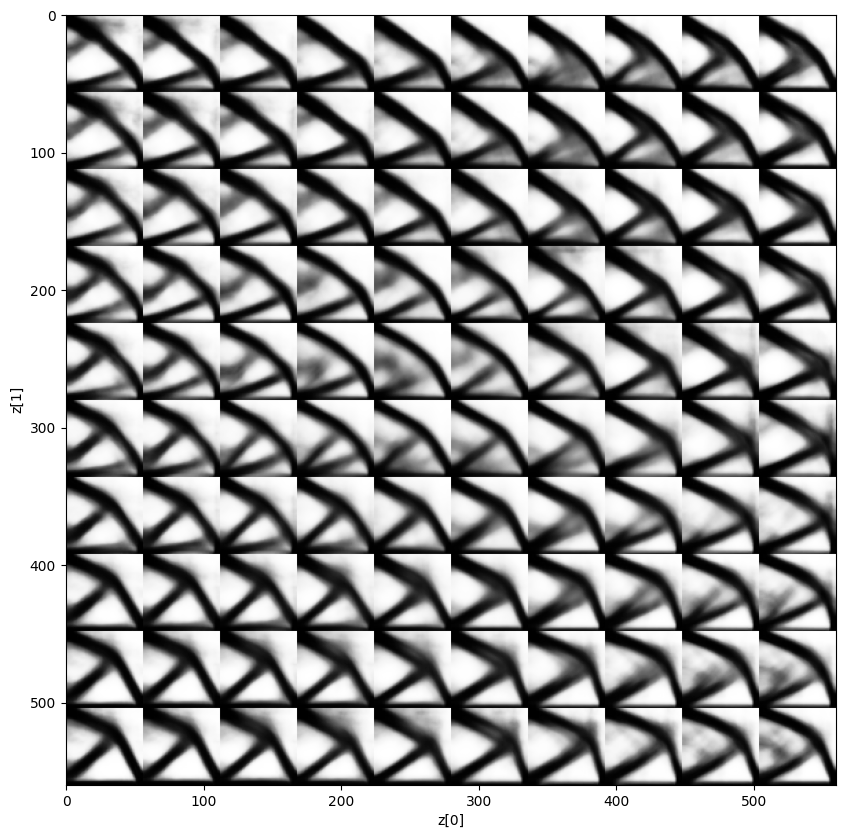

In [ ]:
plot_latent_space(vae)  # call the function to plot the latent space manifold

- Visualize latent space using t-SNE

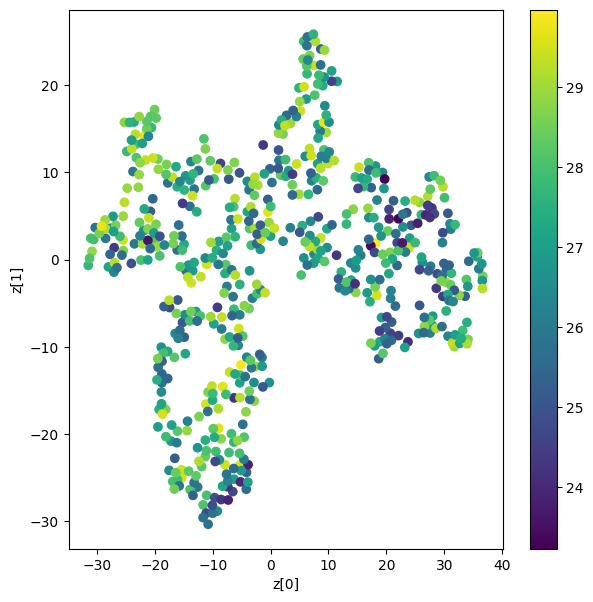

In [ ]:
# set the model to evaluation mode (no gradients will be computed)
vae.eval()

with torch.no_grad():  # disable gradient computation since we're only doing inference
    z_mean, z_logvar = vae.encoder(test_images)  # get the latent vectors (z_mean) and z_logvar for the test images

# convert the latent vectors from PyTorch tensors to NumPy arrays for t-SNE
z_mean_np = z_mean.cpu().detach().numpy()

# apply t-SNE to reduce the latent space to 2 dimensions for visualization
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean_np)

# create a scatter plot of the t-SNE results
plt.figure(figsize=(7, 7))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=test_labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

## 10. Linear interpolation between two points in the latent space

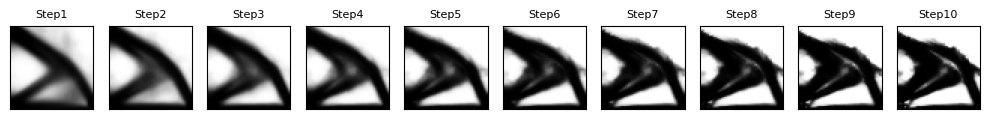

In [ ]:
# define the start and end points in the latent space
target_a = np.array([1, 1])  # start coordinate in the latent space
target_b = np.array([10, 10])  # end coordinate in the latent space

# perform linear interpolation between the two latent points
interpolated_latent_vectors = linear_interpolation(target_a, target_b, steps=10)

# convert the interpolated latent vectors to PyTorch tensors
interpolated_latent_vectors = torch.tensor(interpolated_latent_vectors, dtype=torch.float32).to('cuda')

# use the VAE's decoder to generate images from the interpolated latent vectors
with torch.no_grad():
    z_decoder_imgs = vae.decoder(interpolated_latent_vectors).cpu().detach().numpy()

# visualization of the decoded images generated from the interpolated latent vectors
N = 1  # number of rows of images to display
M = 10  # number of images to display in each row (same as steps + 1)
img_size = 56  # image size (assuming 56x56)

# create a figure to display the images
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)

# plot the interpolated images
for i in range(N):
    for j in range(M):

        k = i * M + j  # calculate index
        ax = fig.add_subplot(N, M, k+1)

        # reshape and display the image
        ax.imshow(np.reshape(z_decoder_imgs[k], (img_size, img_size)), cmap=plt.cm.gist_gray)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

        ax.set_title(f"Step{k + 1}", fontsize=8)

plt.tight_layout()
plt.show()